![](https://article1000.com/wp-content/uploads/2017/08/steganography-hiding-your-secrets-with-php-23-638.jpg)

As this competition is now a bit old i think that what is the task and what are we coding to achieve but if you are new to this competition than i will try to expain the motive of this competition to you so in this you’ll create an efficient and reliable method to detect secret data hidden within innocuous-seeming digital images don't panic you just have to create a model that classifies the image into category of image that is embedded with hidden message or image which has no information hidden in it as this clearly explained by the hosts .**"The goal of the competition is to determine which of the images in the test set (Test/) have hidden messages embedded."**

So what is the motive of this notebook. So to understand the motive you should know why is image processing needed and why it is important you can see 
1. https://www.kaggle.com/tanulsingh077/steganalysis-complete-understanding-and-model this is a great starting point as it significantly explains the task of what is task for the competition and how can we model the problem
2. https://www.kaggle.com/ninjakx01/alaska2-image-analysis-in-spatial-freq-domain this is also a very good notebook for image processing i too have borrowed a some of code from it

<font color="red" size=3>Please UPVOTE this kernel if you like it. It motivates me to produce more quality content :) <br><br>
    Please do comment what your views are and what you understand from this.
    <br><br> Dont't forget to give your suggestions in the comment section </font>

In [ ]:
!pip install opencv-contrib-python

In [ ]:
import pandas as pd
import numpy as np 
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

In [ ]:
path = Path('/kaggle/input/alaska2-image-steganalysis')
folders = ['Cover', 'JMiPOD', 'JUNIWARD', 'UERD']
img_num = 5
img_cov_path = f"{path}/{folders[0]}/0000{img_num}.jpg"
img_jmi_path = f"{path}/{folders[1]}/0000{img_num}.jpg"
img_juni_path = f"{path}/{folders[2]}/0000{img_num}.jpg"
img_uerd_path = f"{path}/{folders[3]}/0000{img_num}.jpg"
img_cov = cv2.imread(img_cov_path, cv2.IMREAD_GRAYSCALE)
img_jmi = cv2.imread(img_juni_path, cv2.IMREAD_GRAYSCALE)
img_juni = cv2.imread(img_juni_path, cv2.IMREAD_GRAYSCALE)
img_uerd = cv2.imread(img_uerd_path, cv2.IMREAD_GRAYSCALE)

In [ ]:
def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

def subtract_gaussian_bg_image(im):
    k = np.max(im.shape)/10
    bg = cv2.GaussianBlur(im ,(0,0) ,k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

1. Brightness is very well known image adjustments<br>
For brightness adjustments we will use gamma as it defines pixel's numerical value and its actual luminance. Without gamma, shades captured by digital cameras wouldn't appear as they did to our eyes (on a standard monitor) this gamma value defines the illuminance of pixels<br>

gamma = 1.0![](https://cdn.cambridgeincolour.com/images/tutorials/gamma_example-g10b.jpg)
gamma = 1/2.2![](https://cdn.cambridgeincolour.com/images/tutorials/gamma_example-g22b.jpg)

2. Contrast Streching
Contrast stretching (often called normalization) is a simple image enhancement technique that attempts to improve the contrast in an image by stretching the range of intensity values it contains to span a desired range of values<br>
Initial Image
![](https://homepages.inf.ed.ac.uk/rbf/HIPR2/images/moo2.gif)
Image after 
![](https://homepages.inf.ed.ac.uk/rbf/HIPR2/images/moo2str1.gif)

In [ ]:
def adjust_gamma(image, gamma):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                for i in np.arange(0, 256)]).astype("uint8")
    
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def contrast_stretching(img):        
    rr, gg, bb = cv2.split(img)    
    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)    
    im = imgray    
    ih, iw = imgray.shape    
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(imgray)    
    for i in range(ih):        
        for j in range(iw):            
            im[i, j] = 255 * ((gg[i, j] - minVal) / (maxVal - minVal))        
    limg = cv2.merge((rr, im, bb))    
    return limg

3. Histogram Normalization 
Histogram modeling techniques (e.g. histogram equalization) provide a good method for modifying the dynamic range and contrast of an image by altering that image such that its intensity histogram has a desired shape. this employs a monotonic, non-linear mapping which re-assigns the intensity values of pixels in the input image such that the output image contains a uniform distribution of intensities (flat histogram)<br>

Initial Image
![](https://homepages.inf.ed.ac.uk/rbf/HIPR2/images/moo2.gif)
After Image
![](https://homepages.inf.ed.ac.uk/rbf/HIPR2/images/moo2heq1.gif)
It differs from the more sophisticated histogram equalization in that it can only apply a linear scaling function to the image pixel values. As a result the resulting image is less harsh.

In [ ]:
def match_imgs(img1_path, img2_path):
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)
    
    if img1.mode != img2.mode:
        log.warning('Unequal image modes (%s vs %s) - converting %s to %s',
                    img1.mode, img2.mode, img1.mode, img2.mode)
        img1 = img1.convert(img2.mode)
    if img1.width != img2.width or img1.height != img2.height:
        log.warning('Dimensions do not match ([%d, %d] vs [%d, %d])',
                    img1.width, img1.height, img2.width, img2.height)
    return img1, img2

def diffed_imgs(img1, img2):
    """ Blatantly checking which pixels are different"""
    for y in range(min(img1.height, img2.height)):
        for x in range(min(img1.width, img2.width)):
            img1_pixel = img1.getpixel((x, y))
            img2_pixel = img2.getpixel((x, y))
            if img1_pixel != img2_pixel:
                yield (x, y), img1_pixel, img2_pixel


def find_diffs(orig_path, stego_path, out_path='file.jpg'):
    """Running function of the above code"""
    orig, stego = match_imgs(orig_path, stego_path)
    out = Image.new('RGB', orig.size, (0, 0, 0)) if out_path else None
    for pos, orig_pixel, stego_pixel in diffed_imgs(orig, stego):
#         log.info('Mismatched pixels at %s: %s vs %s', pos, orig_pixel,
#                  stego_pixel)
        if out:
            out.putpixel(pos, (255, 255, 255))

    if out:
        out.save(out_path)
    a = stego_path.split('/')[-2]
    fig, ax = plt.subplots(figsize=(20, 5))
    im = plt.imread(out_path)
    plt.subplot(141)
    adjusted_15 = adjust_gamma(im, gamma=.5)
    plt.title('Pixel differe '+ a + 'with gamma .5')
    plt.imshow(adjusted_15)   
    plt.subplot(142)
    adjusted_75 = adjust_gamma(im, gamma=.75)
    plt.title('Pixel differe '+ a + 'with gamma .75')
    plt.imshow(adjusted_15) 
    plt.subplot(143)
    adjusted_150 = adjust_gamma(im, gamma=1.5)
    plt.title('Pixel differe '+ a + 'with gamma 1.5')
    plt.imshow(adjusted_15) 
    plt.subplot(144)
    adjusted_15 = adjust_gamma(im, gamma=2)
    plt.title('Pixel differe '+ a + 'with gamma 2')
    plt.imshow(adjusted_15) 

def histogram_normalization(image):    
    hist,bins = np.histogram(image.flatten(),256,[0,256])    
    cdf = hist.cumsum()   
    # cdf_normalized = cdf * hist.max()/ cdf.max()    
    cdf_m = np.ma.masked_equal(cdf,0)    
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())    
    cdf = np.ma.filled(cdf_m,0).astype('uint8')     
    img2 = cdf[image]    
    return img2


def matching(source,template):    
    oldshape = source.shape    
    source1 = source.ravel()    
    template1 = template.ravel()    
    s_values, bin_idx, s_counts = np.unique(source1, return_inverse=True,return_counts=True)    
    t_values, t_counts = np.unique(template1, return_counts=True)    
    s_quantiles = np.cumsum(s_counts).astype(np.float64)    
    s_quantiles /= s_quantiles[-1]    
    t_quantiles = np.cumsum(t_counts).astype(np.float64)    
    t_quantiles /= t_quantiles[-1]    
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)    
    interp_t_values1=interp_t_values.astype(np.uint8)    
    sub=interp_t_values-interp_t_values1    
    interp_t_values1[sub>.5]+=1    
    match_v1=interp_t_values1[bin_idx].reshape(oldshape).astype(np.uint8)       
    return match_v1



def Histo_Specification(source, template):    
    f=[]    
    for x in range(0,3):        
        f.append(matching(source[:,:,x], template[:,:,x]))    
    img = cv2.merge((f[0],f[1],f[2]))     
    return img


def histogram_normalization(image):    
    hist,bins = np.histogram(image.flatten(),256,[0,256])    
    cdf = hist.cumsum()   
    # cdf_normalized = cdf * hist.max()/ cdf.max()    
    cdf_m = np.ma.masked_equal(cdf,0)    
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())    
    cdf = np.ma.filled(cdf_m,0).astype('uint8')     
    img2 = cdf[image]    
    return img2

def diffed_imgs_plt(img1,img2,out_path='file.jpg',cont=True,hist=True):
    img1 = Image.fromarray(img1)
    img2 = Image.fromarray(img2)
    if img1.mode != img2.mode:
        img1 = img1.convert(img2.mode)
    out = Image.new('RGB', img1.size, (0, 0, 0))
    for pos, orig_pixel, stego_pixel in diffed_imgs(img1, img2):
#         log.info('Mismatched pixels at %s: %s vs %s', pos, orig_pixel,
#                  stego_pixel)
        if out:
            out.putpixel(pos, (255, 255, 255))

    if out:
        out.save(out_path)
    im = plt.imread(out_path)
    final = cv2.cvtColor(im, cv2.COLOR_LAB2BGR)
    matplotlib.rc('figure', figsize=[7, 7])
    if cont == True:
        try:
            final = contrast_stretching(final)
        except:
            pass
    if hist == True:
        try:
            final = histogram_normalization(final)
        except:
            pass
    plt.imshow(final)

In [ ]:
find_diffs(img_cov_path,img_jmi_path)

The results are of Pixel difference between the original image and the JMiPOD stegno image with gamma correction

4. Now i will try and see the results of using **CLAHE (Contrast Limited Adaptive Histogram Equalization)** <br>
I will not describe it as it is rather very well explained in the opencv documentation<br>
""In adaptive histogram equalization the image is divided into small blocks called "tiles" . Then each of these blocks are histogram equalized. So in a small area, histogram would confine to a small region. If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied."" -> **OpenCV**


In [ ]:
def plot_the_diff(img_cov_path = img_cov_path,img_jmi_path = img_jmi_path,
                  img_juni_path = img_juni_path , img_uerd_path = img_uerd_path,
                 cont =False ,hist=False):
    
    a = img_cov_path.split('/')[-2]
    b = img_jmi_path.split('/')[-2]
    c = img_juni_path.split('/')[-2]
    d = img_uerd_path.split('/')[-2]
    fig, ax = plt.subplots(figsize=(20, 5))
    plt.subplot(141)
    im = cv2.imread(img_cov_path)
    im = subtract_median_bg_image(im)
    lab= cv2.cvtColor(im, cv2.COLOR_BGR2LAB)

    l, x, y = cv2.split(lab)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl1 = clahe.apply(l)
    diffed_imgs_plt(cl1,cl1,cont = cont , hist = hist)
    plt.title('Pixel differe b/w '+ a + '/' + a)
    
    plt.subplot(142)
    im = cv2.imread(img_jmi_path)
    im = subtract_median_bg_image(im)
    lab= cv2.cvtColor(im, cv2.COLOR_BGR2LAB)

    l, x, y = cv2.split(lab)
    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl2 = clahe.apply(l)
    diffed_imgs_plt(cl1,cl2,cont = cont , hist = hist)
    plt.title('Pixel differe b/w ' + a + '/' + b)

    plt.subplot(143)
    im = cv2.imread(img_juni_path)
    im = subtract_median_bg_image(im)
    lab= cv2.cvtColor(im, cv2.COLOR_BGR2LAB)

    l, x, y = cv2.split(lab)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl3 = clahe.apply(l)
    diffed_imgs_plt(cl1,cl3,cont = cont , hist = hist)
    plt.title('Pixel differe b/w '+ a + '/' + c)

    plt.subplot(144)
    im = cv2.imread(img_uerd_path)
    im = subtract_median_bg_image(im)
    lab= cv2.cvtColor(im, cv2.COLOR_BGR2LAB)

    l, x, y = cv2.split(lab)
    
    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl4 = clahe.apply(l)
    diffed_imgs_plt(cl1,cl4,cont = cont , hist = hist)
    plt.title('Pixel differe b/w '+ a + '/' + d)

In [ ]:
plot_the_diff()

Okay so we can see clear difference between the cover and JMiPOD ,cover and JUNIWARD,Cover with Uerd this shows very pleasing different between the different segnography techniques and non stegnography images note- we have not used contrast streaching and histogram normalization because CLAHE takes care of it

Following cells are just experiments of applying contrast streching and Normalization after Pixel differencing is done(to see how it works please see the **'diffed_img_plt'** function above 

In [ ]:
plot_the_diff(cont = True)

In [ ]:
plot_the_diff(hist = True)

In [ ]:
plot_the_diff(cont=True,hist=True)

We can see some interesting results of applying histogram normalization and contrast streaching after pixel differencing as more and more 
intriguing differences between images can be found

In [ ]:
def diff_histo(img_cov_path = img_cov_path,img_jmi_path = img_jmi_path,
                  img_juni_path = img_juni_path , img_uerd_path = img_uerd_path,
                  cont = True,hist=True):
    
    a = img_cov_path.split('/')[-2]
    b = img_jmi_path.split('/')[-2]
    c = img_juni_path.split('/')[-2]
    d = img_uerd_path.split('/')[-2]
    fig, ax = plt.subplots(figsize=(20, 5))
    plt.subplot(141)
    im = cv2.imread(img_cov_path)
    im = subtract_median_bg_image(im)
    lab= cv2.cvtColor(im, cv2.COLOR_BGR2LAB)

    l, x, y = cv2.split(lab)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl1 = clahe.apply(l)
    cl2 = cl1
    cl3 = cl1
    img = cv2.merge((cl1,cl2,cl3))
    cl1 = Histo_Specification(img, img)
    diffed_imgs_plt(cl1,cl1,cont = cont , hist = hist)
    plt.title('Pixel differe b/w ' + a + '/' + a)
    
    plt.subplot(142)
    im = cv2.imread(img_jmi_path)
    im = subtract_median_bg_image(im)
    lab= cv2.cvtColor(im, cv2.COLOR_BGR2LAB)

    l, x, y = cv2.split(lab)
    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl1 = clahe.apply(l)
    cl2 = cl1
    cl3 = cl1
    img1 = cv2.merge((cl1,cl2,cl3))
    cl2 = Histo_Specification(img, img1)
    diffed_imgs_plt(cl1,cl2,cont = cont , hist = hist)
    plt.title('Pixel differe b/w ' + a + '/' + b)

    plt.subplot(143)
    im = cv2.imread(img_juni_path)
    im = subtract_median_bg_image(im)
    lab= cv2.cvtColor(im, cv2.COLOR_BGR2LAB)

    l, x, y = cv2.split(lab)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl1 = clahe.apply(l)
    cl2 = cl1
    cl3 = cl1
    img2 = cv2.merge((cl1,cl2,cl3))
    cl3 = Histo_Specification(img, img2)
    diffed_imgs_plt(cl1,cl3,cont = cont , hist = hist)
    plt.title('Pixel differe b/w ' + a + '/' + c)

    plt.subplot(144)
    im = cv2.imread(img_uerd_path)
    im = subtract_median_bg_image(im)
    lab= cv2.cvtColor(im, cv2.COLOR_BGR2LAB)

    l, x, y = cv2.split(lab)
    
    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl1 = clahe.apply(l)
    cl2 = cl1
    cl3 = cl1
    img3 = cv2.merge((cl1,cl2,cl3))
    cl4 = Histo_Specification(img, img3)
    diffed_imgs_plt(cl1,cl4,cont = cont , hist = hist)
    plt.title('Pixel differe b/w ' + a + '/' + d)

In [ ]:
diff_histo()

In [ ]:
def Root_Channel_SQUR(crop):    
    blu=crop[:,:,0].astype(np.int32)    
    gre=crop[:,:,1].astype(np.int32)    
    red=crop[:,:,2].astype(np.int32)      
    lll=(((blu**2)+(gre**2)+(red**2))/float(3))**0.5    
    lll=lll.astype(np.uint8)#1st version of image    
    return lll


a = img_cov_path.split('/')[-2]
b = img_jmi_path.split('/')[-2]
c = img_juni_path.split('/')[-2]
d = img_uerd_path.split('/')[-2]
im = cv2.imread(img_cov_path)
Root_Channel_SQUR_image = Root_Channel_SQUR(im)
im = subtract_median_bg_image(im)
Root_Channel_SQUR_image = subtract_median_bg_image(Root_Channel_SQUR_image)
plt.imshow(Root_Channel_SQUR_image)

fig, ax = plt.subplots(figsize=(20, 5))
plt.subplot(141)
im = cv2.imread(img_cov_path)
Root_Channel_SQUR_image = Root_Channel_SQUR(im)
im = subtract_median_bg_image(im)
Root_Channel_SQUR_image = subtract_median_bg_image(Root_Channel_SQUR_image)
diffed_imgs_plt(Root_Channel_SQUR_image,Root_Channel_SQUR_image)
plt.title('Pixel differe b/w ' + a + '/' + a)

plt.subplot(142)
im1 = cv2.imread(img_juni_path)
Root_Channel_SQUR_image1 = Root_Channel_SQUR(im1)
im1 = subtract_median_bg_image(im1)
Root_Channel_SQUR_image1 = subtract_median_bg_image(Root_Channel_SQUR_image1)
diffed_imgs_plt(Root_Channel_SQUR_image,Root_Channel_SQUR_image1)
plt.title('Pixel differe b/w ' + a + '/' + b)

plt.subplot(143)
im2 = cv2.imread(img_jmi_path)
Root_Channel_SQUR_image2 = Root_Channel_SQUR(im2)
im2 = subtract_median_bg_image(im2)
Root_Channel_SQUR_image2 = subtract_median_bg_image(Root_Channel_SQUR_image2)
diffed_imgs_plt(Root_Channel_SQUR_image,Root_Channel_SQUR_image2)
plt.title('Pixel differe b/w ' + a + '/' + c)

plt.subplot(144)
im3 = cv2.imread(img_uerd_path)
Root_Channel_SQUR_image3 = Root_Channel_SQUR(im3)
im3 = subtract_median_bg_image(im3)
Root_Channel_SQUR_image3 = subtract_median_bg_image(Root_Channel_SQUR_image3)
diffed_imgs_plt(Root_Channel_SQUR_image,Root_Channel_SQUR_image3)
plt.title('Pixel differe b/w ' + a + '/' + d)

**Root_Channel_SQUR** in this function different channels values are just squared,added and then we take square root of values leading us to have a single channel of image. the squaring and then adding leads to increase which is then further drowned by taking the root

In [ ]:
def Krischer(crop):    
    Input=crop[:,:,1]    
    a,b=Input.shape    
    Kernel=np.zeros((3,3,8))#windows declearations(8 windows)    
    Kernel[:,:,0]=np.array([[5,5,5],[-3,0,-3],[-3,-3,-3]])     
    Kernel[:,:,1]=np.array([[-3,5,5],[-3,0,5],[-3,-3,-3]])    
    Kernel[:,:,2]=np.array([[-3,-3,5],[-3,0,5],[-3,-3,5]])    
    Kernel[:,:,3]=np.array([[-3,-3,-3],[-3,0,5],[-3,5,5]])    
    Kernel[:,:,4]=np.array([[-3,-3,-3],[-3,0,-3],[5,5,5]])    
    Kernel[:,:,5]=np.array([[-3,-3,-3],[5,0,-3],[5,5,-3]])    
    Kernel[:,:,6]=np.array([[5,-3,-3],[5,0,-3],[5,-3,-3]])    
    Kernel[:,:,7]=np.array([[5,5,-3],[5,0,-3],[-3,-3,-3]])    
    #Kernel=(1/float(15))*Kernel    
    #Convolution output    
    dst=np.zeros((a,b,8))    
    for x in range(0,8):        
        dst[:,:,x] = cv2.filter2D(Input,-1,Kernel[:,:,x])    
    Out=np.zeros((a,b))    
    for y in range(0,a-1):        
        for z in range(0,b-1):            
            Out[y,z]=max(dst[y,z,:])    
    Out=np.uint8(Out)            
    return Out


a = img_cov_path.split('/')[-2]
b = img_jmi_path.split('/')[-2]
c = img_juni_path.split('/')[-2]
d = img_uerd_path.split('/')[-2]
im = cv2.imread(img_cov_path)
Krisch = Krischer(im)
im = subtract_median_bg_image(im)
Krisch = subtract_median_bg_image(Krisch)
plt.imshow(Krisch)

fig, ax = plt.subplots(figsize=(20, 5))
plt.subplot(141)
im = cv2.imread(img_cov_path)
Krisch = Krischer(im)
im = subtract_median_bg_image(im)
Krisch = subtract_median_bg_image(Krisch)
diffed_imgs_plt(Krisch,Krisch)
plt.title('Pixel differe b/w ' + a + '/' + a)

plt.subplot(142)
im1 = cv2.imread(img_juni_path)
Krisch1 = Krischer(im1)
im1 = subtract_median_bg_image(im1)
Krisch1 = subtract_median_bg_image(Krisch1)
diffed_imgs_plt(Krisch,Krisch1)
plt.title('Pixel differe b/w ' + a + '/' + b)

plt.subplot(143)
im2 = cv2.imread(img_jmi_path)
Krisch2 = Krischer(im2)
im2 = subtract_median_bg_image(im2)
Krisch2 = subtract_median_bg_image(Krisch2)
diffed_imgs_plt(Krisch,Krisch2)
plt.title('Pixel differe b/w ' + a + '/' + c)

plt.subplot(144)
im3 = cv2.imread(img_uerd_path)
Krisch3 = Krischer(im3)
im3 = subtract_median_bg_image(im3)
Krisch3 = subtract_median_bg_image(Krisch3)
diffed_imgs_plt(Krisch,Krisch3)
plt.title('Pixel differe b/w ' + a + '/' + d)

The **Kirsch operator** or Kirsch compass kernel is a non-linear edge detector that finds the maximum edge strength in a few predetermined directions. It is named after the computer scientist Russell A. Kirsch. --> wiki<br>
This filter is very easy to code and is very versitile in detecting the edges in all of the eight directions.First every filter is convolved over the image and than the max of the filtered values are intercepted after this the differencing is done. according to the images above kirsch filter perform well to detect the anomalities.
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/7d0ec899c8248a8a2e38e7e71f17a1f6772c5b92)

**HOG(Histogram of Oriented Gradients)** is a feature descriptor that is often used to extract features from image data. It is widely used in computer vision tasks for object detection.The HOG descriptor focuses on the structure or the shape of an object. The HOG feature descriptor counts the occurrences of gradient orientation in localized portions of an image.
![](https://www.learnopencv.com/wp-content/uploads/2016/12/hog-cell-gradients.png)

In [ ]:
from skimage.feature import hog

def hog_images(crop):    
    image=crop[:,:,1]    
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4),cells_per_block=(2, 2), visualize=True)    
    return hog_image

a = img_cov_path.split('/')[-2]
b = img_jmi_path.split('/')[-2]
c = img_juni_path.split('/')[-2]
d = img_uerd_path.split('/')[-2]
im = cv2.imread(img_cov_path)
hog_image = hog_images(im)
plt.imshow(hog_image)

fig, ax = plt.subplots(figsize=(20, 5))
plt.subplot(141)
im = cv2.imread(img_cov_path)
hog_image = hog_images(im)
diffed_imgs_plt(hog_image,hog_image)
plt.title('Pixel differe b/w ' + a + '/' + a)

plt.subplot(142)
im1 = cv2.imread(img_juni_path)
hog_image1 = hog_images(im1)
im1 = subtract_median_bg_image(im1)
diffed_imgs_plt(hog_image,hog_image1)
plt.title('Pixel differe b/w ' + a + '/' + b)

plt.subplot(143)
im2 = cv2.imread(img_jmi_path)
hog_image2 = hog_images(im2)
diffed_imgs_plt(hog_image,hog_image2)
plt.title('Pixel differe b/w ' + a + '/' + c)

plt.subplot(144)
im3 = cv2.imread(img_uerd_path)
hog_image3 = hog_images(im3)
diffed_imgs_plt(hog_image,hog_image3)
plt.title('Pixel differe b/w ' + a + '/' + d)

In [ ]:
def Tan_inv(crop):    
    gre=crop[:,:,1].astype(np.float64)    
    red=crop[:,:,2].astype(np.float64)        
    red[red==0]=0.000001    
    m=gre/red   
    n=np.arctan(m) 
    ij=(n*255)/3.14    
    j=ij.astype(np.uint8)    
    equ = cv2.equalizeHist(j)    
    return equ


a = img_cov_path.split('/')[-2]
b = img_jmi_path.split('/')[-2]
c = img_juni_path.split('/')[-2]
d = img_uerd_path.split('/')[-2]
im = cv2.imread(img_cov_path)
Tan_inv1 = Tan_inv(im)
plt.imshow(Tan_inv1)

fig, ax = plt.subplots(figsize=(20, 5))
plt.subplot(141)
im = cv2.imread(img_cov_path)
Tan_inv1 = Tan_inv(im)
diffed_imgs_plt(Tan_inv1,Tan_inv1)
plt.title('Pixel differe b/w ' + a + '/' + a)

plt.subplot(142)
im1 = cv2.imread(img_juni_path)
Tan_inv2 = Tan_inv(im1)
diffed_imgs_plt(Tan_inv1,Tan_inv2)
plt.title('Pixel differe b/w ' + a + '/' + b)

plt.subplot(143)
im2 = cv2.imread(img_jmi_path)
Tan_inv3 = Tan_inv(im2)
diffed_imgs_plt(Tan_inv1,Tan_inv3)
plt.title('Pixel differe b/w ' + a + '/' + c)

plt.subplot(144)
im3 = cv2.imread(img_uerd_path)
Tan_inv4 = Tan_inv(im3)
diffed_imgs_plt(Tan_inv1,Tan_inv4)
plt.title('Pixel differe b/w ' + a + '/' + d)

Tan_inv function does not perform as well as the other functions as it does not signifies much difference between the images and stegnography images

**FFT(Fourier Transform)** - fft decomposes an image into its real and imaginary components which is a representation of the image in the frequency domain. If the input signal is an image then the number of frequencies in the frequency domain is equal to the number of pixels in the image or spatial domain. The inverse transform re-transforms the frequencies to the image in the spatial domain.The Fourier Transform is used in a wide range of applications, such as image analysis, image filtering, image reconstruction and image compression.But why we use this fft .Image has changes in brighness level according to picture. The brightness changes in rows and columns. We can consider brightness level in a row as a discrete signal 1D and we can apply DFT. same way DFT is applied for each row or column and corresponding DFT row or column is generated.So through this we can analyze the changes in the brightness between the non stegno and stegno images
![](https://www.clear.rice.edu/elec301/Projects01/image_filt/matlab/spectrum.gif)
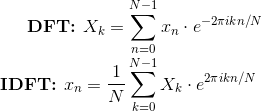

In [ ]:
img = cv2.imread(img_cov_path,0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
fig, ax = plt.subplots(figsize=(20, 5))
plt.subplot(131)
plt.imshow(img, cmap = 'gray')
plt.title('cover Input Image')
plt.subplot(132)
plt.imshow(img_back, cmap = 'gray')
plt.title('cover image with absolute fft values')
plt.subplot(133)
plt.imshow(img_back)
plt.title('cover image after fft ')


img = cv2.imread(img_juni_path,0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
fig, ax = plt.subplots(figsize=(20, 5))
plt.subplot(131)
plt.imshow(img, cmap = 'gray')
plt.title('juni Input Image')
plt.subplot(132)
plt.imshow(img_back, cmap = 'gray')
plt.title('juni image with absolute fft values')
plt.subplot(133)
plt.imshow(img_back)
plt.title('juni image after fft ')


img = cv2.imread(img_jmi_path,0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
fig, ax = plt.subplots(figsize=(20, 5))
plt.subplot(131)
plt.imshow(img, cmap = 'gray')
plt.title('jmi Input Image')
plt.subplot(132)
plt.imshow(img_back, cmap = 'gray')
plt.title('jmi image with absolute fft values')
plt.subplot(133)
plt.imshow(img_back)
plt.title('jmi image after fft ')

img = cv2.imread(img_uerd_path,0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
fig, ax = plt.subplots(figsize=(20, 5))
plt.subplot(131)
plt.imshow(img, cmap = 'gray')
plt.title('uerd Input Image')
plt.subplot(132)
plt.imshow(img_back, cmap = 'gray')
plt.title('uerd image with absolute fft values')
plt.subplot(133)
plt.imshow(img_back)
plt.title('uerd image after fft ')

Though we can see the difference with naked eye but lets analyze the difference between the cover fft and stegno fft images

In [ ]:
from numpy.fft import fft2
from numpy import r_
def show_dct_bgr(img_num):
    # Let us plot image histogram for cover and stego images in Gray scale:
    fig, ax = plt.subplots(figsize=(20, 10))
    print(f"{path}/{folders[0]}/0000{img_num}.jpg")
    img_cov = cv2.imread(f"{path}/{folders[0]}/0000{img_num}.jpg", -1)
    img_jmi = cv2.imread(f"{path}/{folders[1]}/0000{img_num}.jpg", -1)
    img_juni = cv2.imread(f"{path}/{folders[2]}/0000{img_num}.jpg", -1)
    img_uerd = cv2.imread(f"{path}/{folders[3]}/0000{img_num}.jpg", -1)
    
    imsize = img_cov.shape
    
    fft_cov = np.zeros(imsize)
    fft_jmi = np.zeros(imsize)
    fft_juni = np.zeros(imsize)
    fft_uerd = np.zeros(imsize) 
    
    for i in r_[:imsize[0]:4]:
        for j in r_[:imsize[1]:4]:
            fft_cov[:,:,0] [i:(i+4),j:(j+4)] = fft2( img_cov[:,:,0][i:(i+4),j:(j+4)] )
            fft_jmi[:,:,0] [i:(i+4),j:(j+4)] = fft2( img_jmi[:,:,0][i:(i+4),j:(j+4)] )
            fft_juni[:,:,0][i:(i+4),j:(j+4)] = fft2( img_juni[:,:,0][i:(i+4),j:(j+4)] )
            fft_uerd[:,:,0][i:(i+4),j:(j+4)] = fft2( img_uerd[:,:,0][i:(i+4),j:(j+4)] )

            fft_cov[:,:,1][i:(i+4),j:(j+4)] = fft2( img_cov[:,:,1][i:(i+4),j:(j+4)] )
            fft_jmi[:,:,1][i:(i+4),j:(j+4)] = fft2( img_jmi[:,:,1][i:(i+4),j:(j+4)] )
            fft_juni[:,:,1][i:(i+4),j:(j+4)] = fft2( img_juni[:,:,1][i:(i+4),j:(j+4)] )
            fft_uerd[:,:,1][i:(i+4),j:(j+4)] = fft2( img_uerd[:,:,1][i:(i+4),j:(j+4)] )
            
            fft_cov[:,:,2][i:(i+4),j:(j+4)] = fft2( img_cov[:,:,2][i:(i+4),j:(j+4)] )
            fft_jmi[:,:,2][i:(i+4),j:(j+4)] = fft2( img_jmi[:,:,2][i:(i+4),j:(j+4)] )
            fft_juni[:,:,2][i:(i+4),j:(j+4)] = fft2( img_juni[:,:,2][i:(i+4),j:(j+4)] )
            fft_uerd[:,:,2][i:(i+4),j:(j+4)] = fft2( img_uerd[:,:,2][i:(i+4),j:(j+4)] )
 
   #################################

    plt.subplot(141)
    plt.title("Cover")
    plt.imshow(img_cov)

    plt.subplot(142)
    plt.title("JMiPOD")
    plt.imshow(img_jmi)

    plt.subplot(143)
    plt.title("JUNIWARD")
    plt.imshow(img_juni)

    plt.subplot(144)
    plt.title("UERD")
    plt.imshow(img_uerd)

    plt.show()    
  

    #################################
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.subplot(141)
    plt.title("ffT on Cover")
    plt.imshow(fft_cov)

    plt.subplot(142)
    plt.title("ffT on JMiPOD")
    plt.imshow(fft_jmi)

    plt.subplot(143)
    plt.title("ffT on JUNIWARD")
    plt.imshow(fft_juni)

    plt.subplot(144)
    plt.title("ffT on UERD")
    plt.imshow(fft_uerd)

    plt.show()
 
    #########################################
    
    diff_cov_jmi = fft_cov - fft_jmi
    diff_cov_juni = fft_cov - fft_juni
    diff_cov_uerd = fft_cov - fft_uerd
    ########################################
    
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.subplot(141)
    plt.title("ffT Cover")
    plt.imshow(fft_cov)

    plt.subplot(142)
    plt.title("ffT Cover - ffT JMiPOD")
    plt.imshow(diff_cov_jmi)

    plt.subplot(143)
    plt.title("ffT Cover - ffT JUNIWARD")
    plt.imshow(diff_cov_juni)

    plt.subplot(144)
    plt.title("ffT Cover - ffT UERD")
    plt.imshow(diff_cov_uerd)

    plt.show()

In [ ]:
show_dct_bgr(5)

**Sober** - Edges in images are areas with strong intensity contrasts; a jump in intensity from one pixel to the next. The process of edge detection significantly reduces the amount of data and filters out uneeded information, while preserving the important structural properties of an image. This algorithms has 2 filters
![](https://automaticaddison.com/wp-content/uploads/2019/12/11-x-y-direction-kernel.jpg)these filter are then convolved over the image and than sumed<br>
Gx = x-direction kernel * (3×3 portion of image A with (x,y) as the center cell)<br>
Gy = y-direction kernel * (3×3 portion of image A with (x,y) as the center cell)<br>
magnitude(G) = square_root(Gx2 + Gy2)<br>
The direction of the gradient Ɵ at pixel (x, y) is: Ɵ = atan(Gy / Gx)<br>

**Laplacian** - 
To understand the laplacian filter we assume that we have a graph of the intensity values for each pixel in an image, the Sobelfilter takes the derivative if the intensity is at ist maxima than we can have a edge in the region.One limitation with the approach above is that the first derivative of an image might be subject to a lot of noise. Local peaks in the slope of the intensity values might be due to shadows or tiny color changes that are not edges at all. So this might lead us to get the edges but we will also have some noise as classified edges so an alternative to use is to take first derivative of an image and then second derivative, 
An edge occurs where the graph of the second derivative crosses zero. This second derivative-based method is called the Laplacian algorithm. 
We also set a threshold value to distinguish noise from edges. If the second derivative magnitude at a pixel exceeds this threshold, the pixel is part of an edge.
![](https://automaticaddison.com/wp-content/uploads/2019/12/5-log.jpg)

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread(img_cov_path,-1)

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)

img1 = cv2.imread(img_jmi_path,-1)

laplacian1 = cv2.Laplacian(img1,cv2.CV_64F)
sobelx1 = cv2.Sobel(img1,cv2.CV_64F,1,0,ksize=5)
fig, ax = plt.subplots(figsize=(20, 10))
plt.subplot(2,3,1),plt.imshow(img-img1,cmap = 'gray')
plt.title('Original pix diff jmi'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(laplacian-laplacian1,cmap = 'gray')
plt.title('Laplacian pix diff jmi'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3),plt.imshow(sobelx-sobelx1,cmap = 'gray')
plt.title('SobelX pix diff jmi'), plt.xticks([]), plt.yticks([])
plt.show()

img2 = cv2.imread(img_juni_path,-1)

laplacian2 = cv2.Laplacian(img2,cv2.CV_64F)
sobelx2 = cv2.Sobel(img2,cv2.CV_64F,1,0,ksize=5)
fig, ax = plt.subplots(figsize=(20, 10))
plt.subplot(2,3,1),plt.imshow(img-img2,cmap = 'gray')
plt.title('Original pix diff juni'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(laplacian-laplacian2,cmap = 'gray')
plt.title('Laplacian pix diff juni'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3),plt.imshow(sobelx-sobelx2,cmap = 'gray')
plt.title('SobelX pix diff juni'), plt.xticks([]), plt.yticks([])
plt.show()


img3 = cv2.imread(img_uerd_path,-1)

laplacian3 = cv2.Laplacian(img3,cv2.CV_64F)
sobelx3 = cv2.Sobel(img3,cv2.CV_64F,1,0,ksize=5)
fig, ax = plt.subplots(figsize=(20, 10))
plt.subplot(2,3,1),plt.imshow(img-img3,cmap = 'gray')
plt.title('Original pix diff uerd'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(laplacian-laplacian3,cmap = 'gray')
plt.title('Laplacian pix diff uerd'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3),plt.imshow(sobelx-sobelx3,cmap = 'gray')
plt.title('Sobel X pix diff uerd'), plt.xticks([]), plt.yticks([])
plt.show()


**Local binary patterns** <br>

(LBP) is a type of visual descriptor used for classification in computer vision. LBP is the particular case of the Texture Spectrum model  LBP was first described in 1994.It has since been found to be a powerful feature for texture classification; it has further been determined that when LBP is combined with the Histogram of oriented gradients (HOG) descriptor, it improves the detection performance considerably on some datasets.A comparison of several improvements of the original LBP in the field of background subtraction was made in 2015 by Silva et al. A full survey of the different versions of LBP can be found in Bouwmans et al.<br>

![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn-images-1.medium.com%2Fmax%2F2400%2F1*vBddGyANCoj4PYiKNptXnQ.png&f=1&nofb=1)

code insperation - https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

In [ ]:
# import the necessary packages
from skimage import feature

def LocalBinaryPatterns(image1_path,image2_path,image3_path,image4_path):
    p,r = 8,1
    fig, ax = plt.subplots(figsize=(20, 10))
    img_cov = cv2.imread(image1_path, -1)
    gray_cov = cv2.cvtColor(img_cov, cv2.COLOR_BGR2GRAY)
    ldp = feature.local_binary_pattern(gray_cov, p,
            r, method="uniform")
    plt.subplot(141)
    diffed_imgs_plt(ldp,ldp)
    plt.title('Pixel differe b/w ' + a + '/' + a)
    
    
    img_jmi = cv2.imread(image2_path, -1)
    gray_val = cv2.cvtColor(img_jmi, cv2.COLOR_BGR2GRAY)
    ldp2 = feature.local_binary_pattern(gray_val, p,
            r, method="uniform")
    plt.subplot(142)
    diffed_imgs_plt(ldp,ldp2)
    plt.title('Pixel differe b/w ' + a + '/' + b)
    
    
    img_juni = cv2.imread(image3_path, -1)
    gray_val = cv2.cvtColor(img_juni, cv2.COLOR_BGR2GRAY)
    ldp3 = feature.local_binary_pattern(gray_val, p,
            r, method="uniform")
    plt.subplot(143)
    diffed_imgs_plt(ldp,ldp3)
    plt.title('Pixel differe b/w ' + a + '/' + c)
    
    
    img_uerd = cv2.imread(image4_path, -1)
    gray_val = cv2.cvtColor(img_uerd, cv2.COLOR_BGR2GRAY)
    ldp4 = feature.local_binary_pattern(gray_val, p,
            r, method="uniform")
    plt.subplot(144)
    diffed_imgs_plt(ldp,ldp4)
    plt.title('Pixel differe b/w ' + a + '/' + d)
    

In [ ]:
LocalBinaryPatterns(img_cov_path,img_jmi_path,img_juni_path,img_uerd_path)

### Whats Next

1. So you might apply any of these filter to the notebooks as an augmentation this might add a new direction in training
2. Shows how do these filters could find ther underlying features so what you can do is to stack them each other
3. Your can upvote ;-))